This notebook presents the training process and evaluation of our CNN model specifically for Apple disease detection, serving as a representative example of our methodology. The same exact code and approach have been applied to develop and train separate models for each of the eight plant species studied in our project. The demonstrated procedures, analyses, and conclusions drawn for the Apple model closely mirror those used for the other species, providing a comprehensive insight into our overall methodology and model performance across different plant types.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nupurdivekar","key":"971e2dd74963cf712805c358c47d09bb"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d tushar5harma/plant-village-dataset-updated/

 98% 0.99G/1.00G [00:09<00:00, 80.6MB/s]
100% 1.00G/1.00G [00:09<00:00, 110MB/s] 


In [6]:
# @title Default title text
!unzip plant-village-dataset-updated.zip



Streaming output truncated to the last 5000 lines.
  inflating: Tomato/Train/Septoria Leaf Spot/a3938779-9d9f-4e45-a397-7b5abd13f6ba___JR_Sept.L.S 2700.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a4467299-5237-45f5-bb9b-9fd69f7a2b1a___Matt.S_CG 7719.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a45b192c-f31e-4ca1-bf4a-10ff1060e658___Matt.S_CG 7512.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a45bce54-4c25-4d5d-a9a9-fbc76436844c___Matt.S_CG 6523.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a46ff722-2186-4645-9018-01e8e20cfa2a___Matt.S_CG 6511.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a4880706-e191-43ff-a5a7-bd0f0c03aa2d___Keller.St_CG 1851.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a494e2ac-9dbe-47e5-9963-3e99f8eb9d2e___Matt.S_CG 6062.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a49c7f28-4b67-4d95-b79b-26a52dc8b9e5___Matt.S_CG 7583.JPG  
  inflating: Tomato/Train/Septoria Leaf Spot/a5bf2855-754e-4661-86b1-a86f0974cd30___JR_Sept.L.S 2574.JPG

In [32]:
#ls
#!mkdir /content/AppleDisease
!ls /content/Apple/Train

In [33]:
#!mv /content/Apple/Train/'Healthy' /content/AppleDisease
!ls /content/AppleDisease

'Apple Scab'  'Black Rot'  'Cedar Apple Rust'   Healthy


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [36]:
# Set your dataset path and parameters
data_path = "/content/AppleDisease"
batch_size = 32
target_size = (224, 224)
num_epochs = 24

In [37]:
# Reverting to more aggressive data augmentation
Image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Data generators
train_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 6218 images belonging to 4 classes.
Found 1553 images belonging to 4 classes.


In [38]:
class_names = list(train_generator.class_indices.keys())
class_names

['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']

In [39]:
train_generator.class_indices

{'Apple Scab': 0, 'Black Rot': 1, 'Cedar Apple Rust': 2, 'Healthy': 3}

In [40]:
print("Training samples:", train_generator.samples)
print("Batch size:", train_generator.batch_size)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
print("Calculated steps per epoch:", steps_per_epoch)

Training samples: 6218
Batch size: 32
Calculated steps per epoch: 194


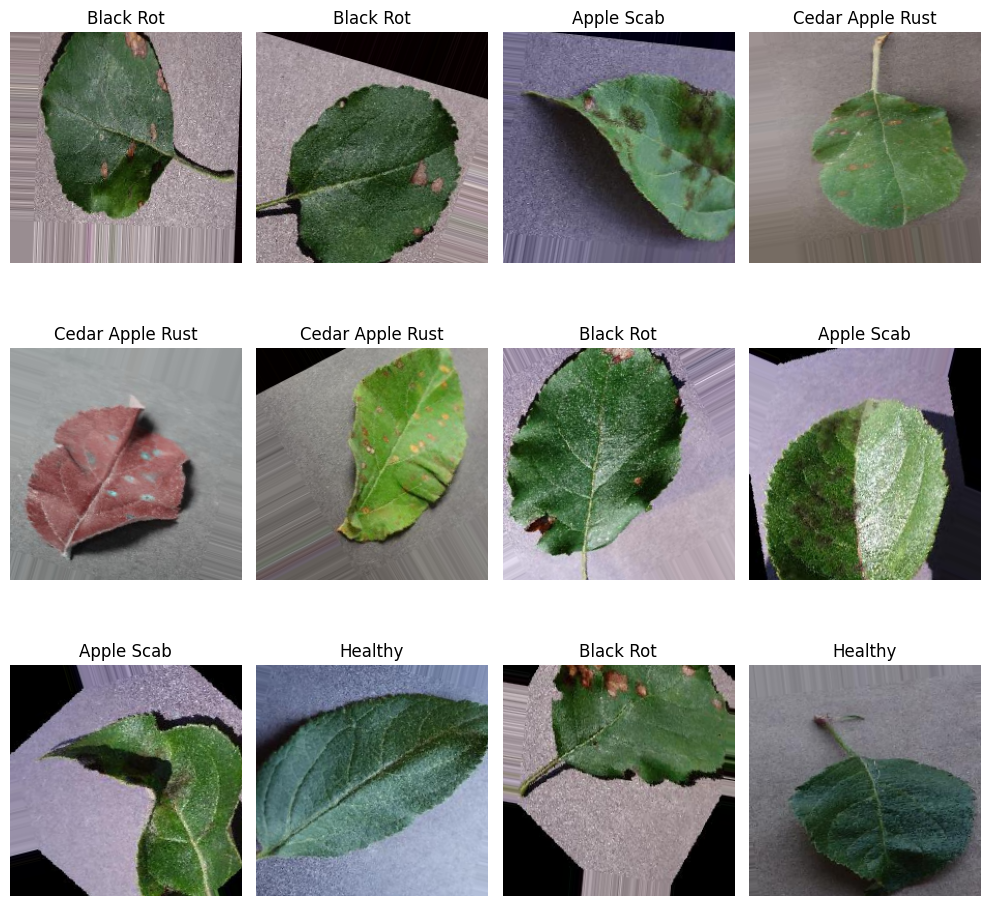

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_generator:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        # If images are normalized (i.e., rescale=1./255), you need to reverse this before displaying
        img_to_display = image_batch[i].astype('uint8') if np.max(image_batch[i]) > 1 else (image_batch[i] * 255).astype('uint8')
        plt.imshow(img_to_display)
        class_index = np.argmax(labels_batch[i])
        plt.title(class_names[class_index])
        plt.axis("off")
    break  # Only display a single batch

plt.tight_layout()
plt.show()



In [42]:

# Model Architecture with increased dropout to combat overfitting
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.6),  # Increased dropout rate
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Reduced learning rate to improve training stability
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Adjusted Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(filepath='grape_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)


In [ ]:

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Found 5779 images belonging to 4 classes.
Found 1443 images belonging to 4 classes.
Epoch 1/24
180/180 [==============================] - ETA: 0s - loss: 0.8691 - accuracy: 0.6494

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - 913s 5s/step - loss: 0.8691 - accuracy: 0.6494 - val_loss: 0.5403 - val_accuracy: 0.7965 - lr: 5.0000e-05
Epoch 2/24
180/180 [==============================] - 912s 5s/step - loss: 0.4814 - accuracy: 0.8173 - val_loss: 0.4486 - val_accuracy: 0.8194 - lr: 5.0000e-05
Epoch 3/24
180/180 [==============================] - 894s 5s/step - loss: 0.4077 - accuracy: 0.8465 - val_loss: 0.3555 - val_accuracy: 0.8660 - lr: 5.0000e-05
Epoch 4/24
180/180 [==============================] - 879s 5s/step - loss: 0.3573 - accuracy: 0.8624 - val_loss: 0.3203 - val_accuracy: 0.8799 - lr: 5.0000e-05
Epoch 5/24
180/180 [==============================] - 913s 5s/step - loss: 0.3161 - accuracy: 0.8778 - val_loss: 0.2876 - val_accuracy: 0.8972 - lr: 5.0000e-05
Epoch 6/24
180/180 [==============================] - 900s 5s/step - loss: 0.2893 - accuracy: 0.8923 - val_loss: 0.2617 - val_accuracy: 0.9083 - lr: 5.0000e-05
Epoch 7/24
180/180 [==============================]

In [ ]:
from google.colab import files
files.download('apple_model.h5')

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [44]:
history

model.summary()
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tushar5harma/plant-village-dataset-updated/
# @title Default title text
!unzip plant-village-dataset-updated.zip
#ls
!mkdir /content/AppleDisease
#!ls /content/Apple/Train
#ls
#!mkdir /content/AppleDisease
!ls /content/Apple/Train
!mv /content/Apple/Train/'Cedar Apple Rust' /content/AppleDisease
!ls /content/AppleDisease
!mv /content/Apple/Train/'Black Rot' /content/AppleDisease
!ls /content/AppleDisease
!mv /content/Apple/Train/'Apple Scab' /content/AppleDisease
!ls /content/AppleDisease
!mv /content/Apple/Train/'Healthy' /content/AppleDisease
!ls /content/AppleDisease
class_names = list(train_generator.class_indices.keys())
class_names
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import Image

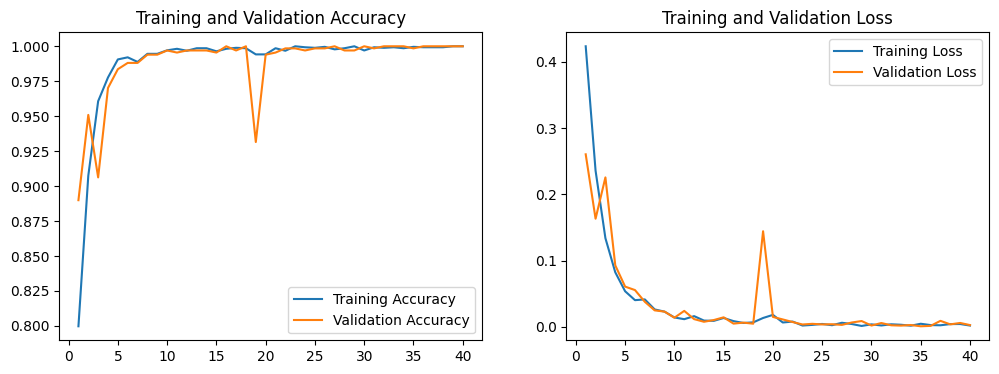

In [26]:
import matplotlib.pyplot as plt

# Data for plotting (for your regular model)
epochs_range = list(range(1, 41))  # 41 epochs
loss = [0.4232, 0.2357, 0.1338, 0.0824, 0.0538, 0.0404, 0.0415, 0.0264, 0.0231, 0.0143, 0.0117, 0.0163, 0.0096, 0.0092, 0.0135, 0.0088, 0.0060, 0.0069, 0.0135, 0.0182, 0.0067, 0.0081, 0.0021, 0.0031, 0.0045, 0.0026, 0.0063, 0.0044, 0.0015, 0.0039, 0.0022, 0.0040, 0.0033, 0.0019, 0.0048, 0.0028, 0.0025, 0.0043, 0.0044, 0.0021]
accuracy = [0.7997, 0.9074, 0.9607, 0.9777, 0.9906, 0.9921, 0.9888, 0.9946, 0.9946, 0.9971, 0.9982, 0.9968, 0.9986, 0.9986, 0.9964, 0.9982, 0.9989, 0.9986, 0.9942, 0.9942, 0.9986, 0.9968, 1.0000, 0.9993, 0.9989, 0.9996, 0.9978, 0.9986, 1.0000, 0.9970, 0.9993, 0.9989, 0.9993, 0.9986, 0.9996, 0.9993, 0.9993, 0.9993,1,1]
val_loss = [0.2603, 0.1632, 0.2255, 0.0929, 0.0608, 0.0556, 0.0379, 0.0250, 0.0231, 0.0139, 0.0242, 0.0118, 0.0078, 0.0104, 0.0145, 0.0050, 0.0065, 0.0049, 0.1443, 0.0151, 0.0113, 0.0074, 0.0037, 0.0047, 0.0038, 0.0041, 0.0031, 0.0067, 0.0089, 0.0021, 0.0059, 0.0025, 0.0020, 0.0029, 0.0010, 0.0016, 0.0092, 0.0039, 0.0060, 0.0028]
val_accuracy = [0.8899, 0.9509, 0.9062, 0.9702, 0.9836, 0.9881, 0.9881, 0.9940, 0.9940, 0.9970, 0.9955, 0.9970, 0.9970, 0.9970, 0.9955, 1.0000, 0.9970, 1.0000, 0.9315, 0.9940, 0.9955, 0.9985, 0.9985, 0.9970, 0.9985, 0.9985, 1.0000, 0.9970, 0.9970, 1.0000, 0.9985, 1.0000, 1.0000, 1.0000, 0.9985, 1.0000, 1.0000, 1.0000,1,1]

# Data for plotting (for your transfer learning model)
# ... (you should have similar data for the transfer learning model)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Evaluating our Model**

Found 196 images belonging to 4 classes.
4/4 [==============================] - 8s 2s/step - loss: 0.3834 - accuracy: 0.8724
Test Loss: 0.3833566904067993
Test Accuracy: 0.8724489808082581
4/4 [==============================] - 8s 1s/step
Image 0: Predicted class - Cedar Apple Rust
Image 1: Predicted class - Apple Scab
Image 2: Predicted class - Apple Scab
Image 3: Predicted class - Apple Scab
Image 4: Predicted class - Apple Scab
Image 5: Predicted class - Apple Scab
Image 6: Predicted class - Apple Scab
Image 7: Predicted class - Apple Scab
Image 8: Predicted class - Apple Scab
Image 9: Predicted class - Apple Scab


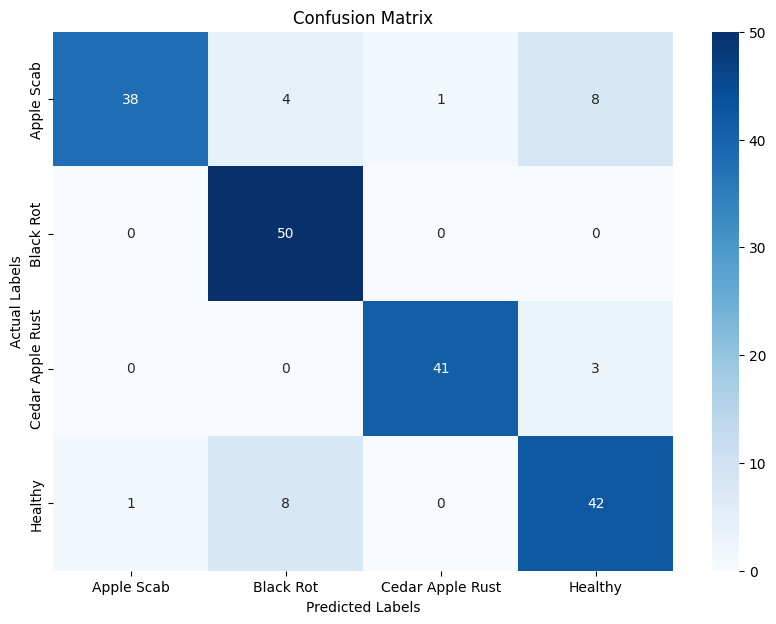

                  precision    recall  f1-score   support

      Apple Scab       0.97      0.75      0.84        51
       Black Rot       0.81      1.00      0.89        50
Cedar Apple Rust       0.98      0.93      0.95        44
         Healthy       0.79      0.82      0.81        51

        accuracy                           0.87       196
       macro avg       0.89      0.88      0.87       196
    weighted avg       0.88      0.87      0.87       196



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns

# Load the trained model
model = load_model('/content/drive/My Drive/GreenSight/apple_model.h5')
test_directory = ('/content/Apple/Test')

image_height = 224
image_width = 224
batch_size = 64
# Preprocess the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' based on your problem
    shuffle=False)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predict on test data (optional)
predictions = model.predict(test_generator)
# Further code to process and analyze predictions...
predicted_class_indices = np.argmax(predictions, axis=1)

# Retrieve the class labels from the test generator
labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())

# Map the predicted indices to the actual class names
predicted_classes = [labels[k] for k in predicted_class_indices]

# (Optional) If you have the actual class labels for the test set,
# you can compare them with the predicted classes to compute metrics
# such as a confusion matrix, precision, recall, etc.

# Print the first few predictions (for example)
for i in range(10):  # Adjust the range as needed
    print(f'Image {i}: Predicted class - {predicted_classes[i]}')

# Optional: Confusion Matrix, Precision, Recall, etc.
# You would need the actual labels for the test set for these metrics
# Example:
from sklearn.metrics import confusion_matrix, classification_report
# Extract actual class labels from test_generator
# Convert predicted indices to class names
predicted_classes = [labels[k] for k in predicted_class_indices]

# Extract actual class labels from test_generator
actual_classes = [test_generator.filenames[i].split('/')[0] for i in range(len(test_generator.filenames))]

cm = confusion_matrix(actual_classes, predicted_classes)

# Convert confusion matrix to a DataFrame for better labeling in seaborn heatmap
cm_df = pd.DataFrame(cm, index=labels.values(), columns=labels.values())

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Print classification report
print(classification_report(actual_classes, predicted_classes))


In [45]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

# Paths to your saved model files
model_paths = [
    '/content/drive/My Drive/GreenSight/apple_model.h5',
    # Add paths to all your models
]

image_dir = '/content/Apple/Test'
image_size = (224, 224)  # The target size for your images
images = []  # List to store the loaded images and labels

# Load images and labels
for class_label in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, class_label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            if os.path.isfile(img_path):
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0
                images.append((img_array, class_label))

# Convert images and labels to numpy arrays
image_arrays = np.array([img[0] for img in images])
image_labels = np.array([img[1] for img in images])

# Convert labels to numeric
unique_labels = list(set(image_labels))
label_to_num = {label: num for num, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_num[label] for label in image_labels])

# One-hot encode labels if needed (depends on your model's configuration)
one_hot_labels = to_categorical(numeric_labels, num_classes=len(unique_labels))

# Define K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1
for model_path in model_paths:
    model = load_model(model_path)
    for train_idx, test_idx in kfold.split(image_arrays):
        test_data = image_arrays[test_idx]
        test_labels = one_hot_labels[test_idx]

        # Evaluate the model
        scores = model.evaluate(test_data, test_labels, verbose=0)
        print(f'Score for fold {fold_no} in model : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        fold_no += 1

# Note: Adjust the label handling (numerical vs. one-hot) based on your model's configuration.


Score for fold 5 in model : loss of 14.906059265136719; accuracy of 2.5641025975346565%
